# Chinook

In [27]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

db = 'chinook.db'

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    q ='''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ('table', 'view')
    '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [2]:
q_genre_purchased = '''
WITH usa_track_sold AS
    (
    SELECT il.*
    FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
    WHERE c.country = "USA"
    )

SELECT
    g.name genre_name,
    COUNT(uts.invoice_line_id) sold_num,
    CAST(COUNT(uts.invoice_line_id) as float) / (
        SELECT COUNT(*) FROM usa_track_sold
    ) sold_pct
FROM usa_track_sold uts
INNER JOIN track t ON t.track_id = uts.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC;
'''
run_query(q_genre_purchased).set_index('genre_name')

,sold_num,sold_pct
genre_name,,
Rock,561,0.533777
Alternative & Punk,130,0.123692
Metal,124,0.117983
R&B/Soul,53,0.050428
Blues,36,0.034253
Alternative,35,0.033302
Latin,22,0.020932
Pop,22,0.020932
Hip Hop/Rap,20,0.019029


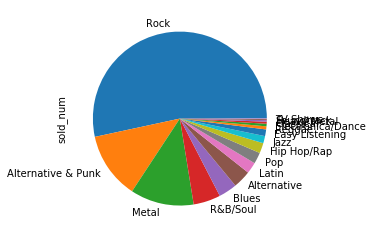

In [7]:
genre_purchased = run_query(q_genre_purchased).set_index('genre_name')
genre_purchased['sold_num'].plot.pie()

In [19]:
q_employee_sales = '''
SELECT
    e.first_name || " " || e.last_name employee_name,
    SUM(i.total) total_sales,
    e2.first_name || " " || e2.last_name boss
FROM employee e
INNER JOIN customer c ON c.support_rep_id = e.employee_id
INNER JOIN invoice i ON i.customer_id = c.customer_id
INNER JOIN employee e2 ON e2.employee_id = e.reports_to
GROUP BY 1
ORDER BY 2 DESC;
'''

run_query(q_employee_sales)

,employee_name,total_sales,boss
0,Jane Peacock,1731.51,Nancy Edwards
1,Margaret Park,1584.00,Nancy Edwards
2,Steve Johnson,1393.92,Nancy Edwards


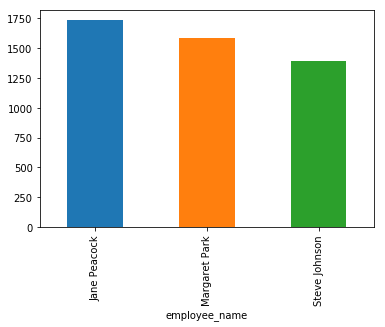

In [23]:
employee_sales = run_query(q_employee_sales).set_index('employee_name')
employee_sales['total_sales'].plot.bar()

In [57]:
q_country = '''
WITH country_summary AS
    (
    SELECT
        CASE
            WHEN (
                SELECT COUNT(*)
                FROM customer
                WHERE country = c.country
            ) = 1 THEN "Other"
            ELSE c.country
        END AS country,
        COUNT(DISTINCT c.customer_id) num_customer,
        SUM(i.total) sum_sales,
        SUM(i.total) / COUNT(DISTINCT c.customer_id) avg_sales_per_customer,
        SUM(i.total) / COUNT(DISTINCT i.invoice_id) avg_sales_per_order
    FROM customer c
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    GROUP BY 1
    ORDER BY 3 DESC
    )

SELECT
    country,
    num_customer,
    sum_sales,
    avg_sales_per_customer,
    avg_sales_per_order
FROM (
    SELECT
        cs.*,
        CASE
            WHEN cs.country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_summary cs
    )
ORDER BY sort;
'''
run_query(q_country)

,country,num_customer,sum_sales,avg_sales_per_customer,avg_sales_per_order
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


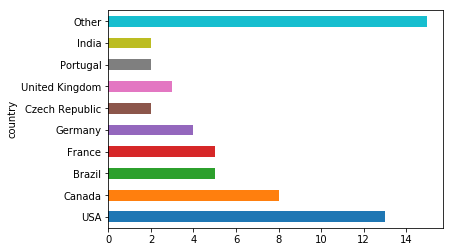

In [139]:
country = run_query(q_country).set_index('country')
country['num_customer'].plot.barh()

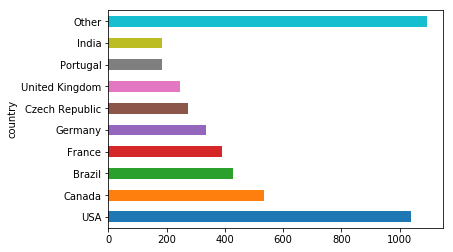

In [63]:
country['sum_sales'].plot.barh()

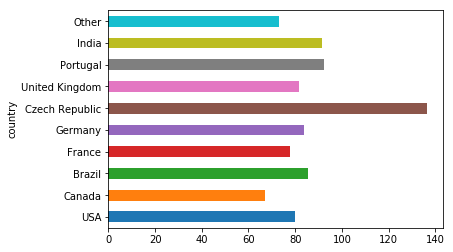

In [64]:
country['avg_sales_per_customer'].plot.barh()

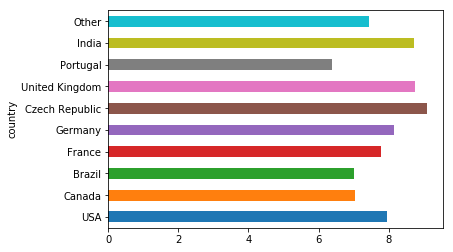

In [65]:
country['avg_sales_per_order'].plot.barh()

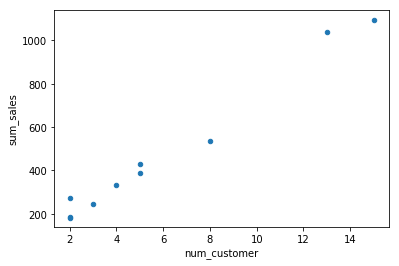

In [69]:
country.plot.scatter('num_customer', 'sum_sales')

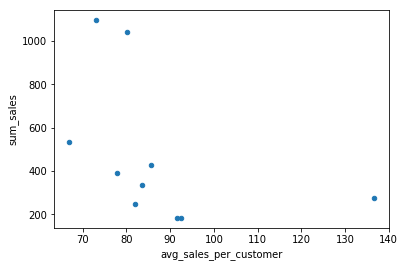

In [70]:
country.plot.scatter('avg_sales_per_customer', 'sum_sales')

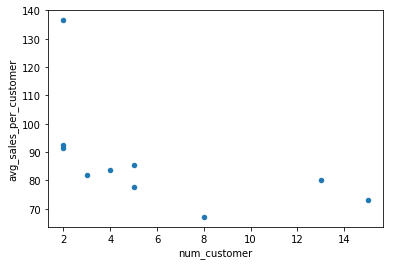

In [71]:
country.plot.scatter('num_customer', 'avg_sales_per_customer')

In [73]:
country_corr = country.corr()
country_corr.style.background_gradient(cmap='coolwarm')

,num_customer,sum_sales,avg_sales_per_customer,avg_sales_per_order
num_customer,1,0.990214,-0.523638,-0.26232
sum_sales,0.990214,1,-0.423775,-0.203947
avg_sales_per_customer,-0.523638,-0.423775,1,0.498845
avg_sales_per_order,-0.26232,-0.203947,0.498845,1


In [133]:
q_invoice = '''
WITH album_tracks AS
    (
    SELECT
        al.album_id,
        COUNT(t.track_id) track_num
    FROM album al
    INNER JOIN track t ON t.album_id = al.album_id
    GROUP BY 1
    ),
    
    album_or_not AS
    (
    SELECT
        il.invoice_id,
        t.album_id,
        al.title,
        COUNT(t.track_id) sold_track_num,
        (
        SELECT track_num
        FROM album_tracks at
        WHERE at.album_id = t.album_id
        ) original_track_num,
        CASE
            WHEN COUNT(t.track_id) = (
                                                    SELECT track_num
                                                    FROM album_tracks at
                                                    WHERE at.album_id = t.album_id
                                                    ) THEN "Album"
            ELSE "Not Album"
        END AS album_or_not                                   
    FROM invoice_line il
    INNER JOIN track t ON t.track_id = il.track_id
    INNER JOIN album al ON al.album_id = t.album_id
    GROUP BY 1
    ORDER BY 1 ASC
    )

SELECT
    COUNT(invoice_id) num,
    CAST(COUNT(invoice_id) as float) / (
                                    SELECT COUNT(a.invoice_id)
                                    FROM album_or_not a
                                    ) pct,
    album_or_not
FROM album_or_not a
GROUP BY a.album_or_not
'''

run_query(q_invoice)

,num,pct,album_or_not
0,125,0.203583,Album
1,489,0.796417,Not Album


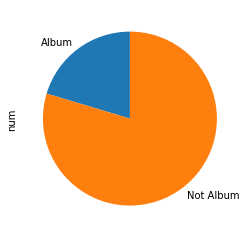

In [137]:
album_num = run_query(q_invoice).set_index('album_or_not')
album_num['num'].plot.pie(startangle=90)